In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from reskan import *
import torch
import numpy as np
import sympy as sp

In [2]:
def sympy_shock_wave_solution(x, t, c, A, gamma):
    return -(gamma / 2)**2 * (t / (1 + (gamma / 2) * t)) * x + (np.exp(-gamma * t / 2) / (1 + (gamma / 2) * t)) * (c - A * np.tanh(A * (np.exp(gamma * t / 2) / (1 + (gamma / 2) * t)) * (x - c * t * np.exp(-gamma * t / 2))))

def lambdify_shock_wave_solution():
    x, t, c, A, gamma = sp.symbols('x t c A gamma')
    U = -(gamma / 2)**2 * (t / (1 + (gamma / 2) * t)) * x + (sp.exp(-gamma * t / 2) / (1 + (gamma / 2) * t)) * (c - A * sp.tanh(A * (sp.exp(gamma * t / 2) / (1 + (gamma / 2) * t)) * (x - c * t * sp.exp(-gamma * t / 2))))
    return sp.lambdify((x, t, c, A, gamma), U, modules='numpy')

def generate_data_from_shock_wave(x_range, t_range, x_steps, t_steps, reg_points, c, A, gamma, noise=0.0, vc_plot=False, device='cpu'):
    x_k = torch.linspace(x_range[0], x_range[1], x_steps, device=device)  # (x_steps,)
    t_k = torch.linspace(t_range[0], t_range[1], t_steps, device=device)  # (t_steps,)

    X_k, T_k = torch.meshgrid(x_k, t_k, indexing='xy')

    X_pde_flat = X_k.reshape(-1, 1)
    T_pde_flat = T_k.reshape(-1, 1)

    input_k = torch.cat([X_pde_flat, T_pde_flat], dim=1)

    x_r = torch.rand(reg_points, 1, device=device) * (x_range[1] - x_range[0]) + x_range[0]
    t_r = torch.rand(reg_points, 1, device=device) * (t_range[1] - t_range[0]) + t_range[0]

    input_r = torch.cat([x_r, t_r], dim=1)

    shock_wave_func = lambdify_shock_wave_solution()
    
    with torch.no_grad():
        x_vals = input_r[:, 0].cpu().numpy()
        t_vals = input_r[:, 1].cpu().numpy()

        U_r_vals = shock_wave_func(x_vals, t_vals, c, A, gamma)
        U_r = torch.tensor(U_r_vals, dtype=torch.float32, device=device).unsqueeze(1)

        if noise > 0.0:
            U_r_std = torch.std(U_r)  
            U_r = U_r + noise * U_r_std * torch.randn_like(U_r)

    input_k = input_k.requires_grad_(True)
    input_r = input_r.requires_grad_(True)
    U_r = U_r.requires_grad_(True)

    if vc_plot:
        return input_k, input_r, U_r, t_k
    else:
        return input_k, input_r, U_r


In [3]:
c = 5
A = 4
gamma = 2
x_range = (-2, 2)
t_range = (0, 2)
x_steps = 100 
t_steps = 50  
points_r = 100  
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_k, input_r, U = generate_data_from_shock_wave(x_range, t_range, x_steps, t_steps, points_r, c, A, gamma, noise=0.05, device=device)



In [4]:
rhs_des = [
 '',
 'x',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}',
 'uu_{x}',
 'u_{xxx}'
 ]

In [5]:
Nd = 50  
Nh = 3   
Nb = 4  
model = VC_PIKAN(Nd=Nd, Nh=Nh, Nb=Nb, rhs_des=rhs_des, range_x=x_range, range_t=t_range, seed=6666, device=device)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [7]:
model.fit(input_r, input_k, U, steps=155, alpha=0.1, lam=0.00, lamb_l1=1., lamb_coef=0.5, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all',save_fig=True, img_folder='tmp')
model.kan_plot()

  0%|          | 0/400 [00:00<?, ?it/s]

Training on cuda


 39%|███▉      | 155/400 [09:33<15:05,  3.70s/it, loss=-5.49, loss_data=0.0037, loss_pde=0.00419, loss_reg=7.71] 


KeyboardInterrupt: 

Original:
After pruning:
saving model version 0.1


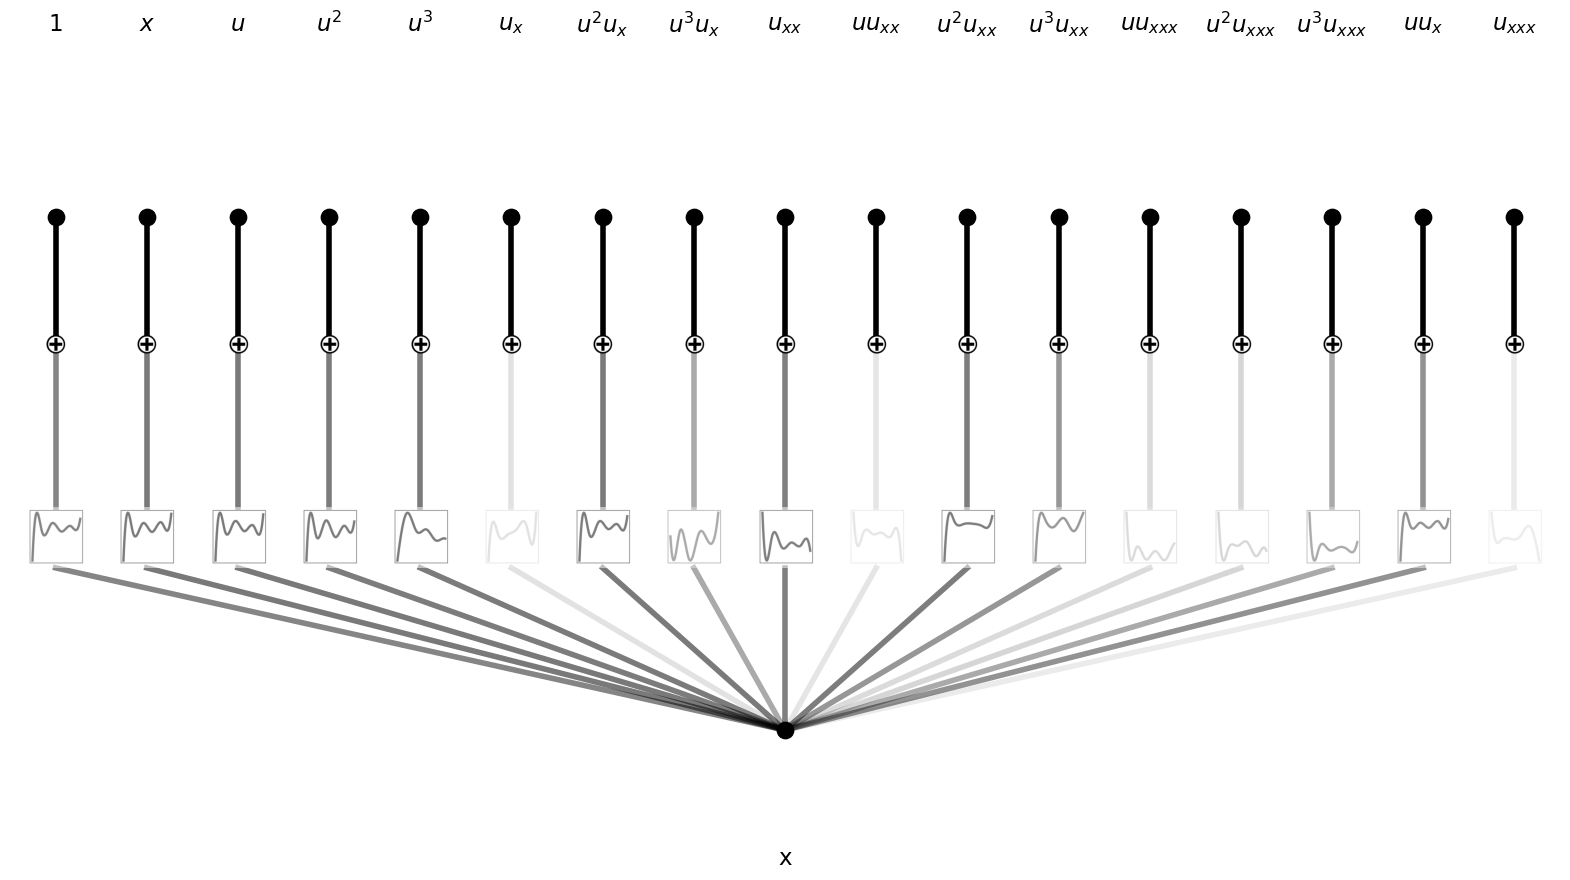

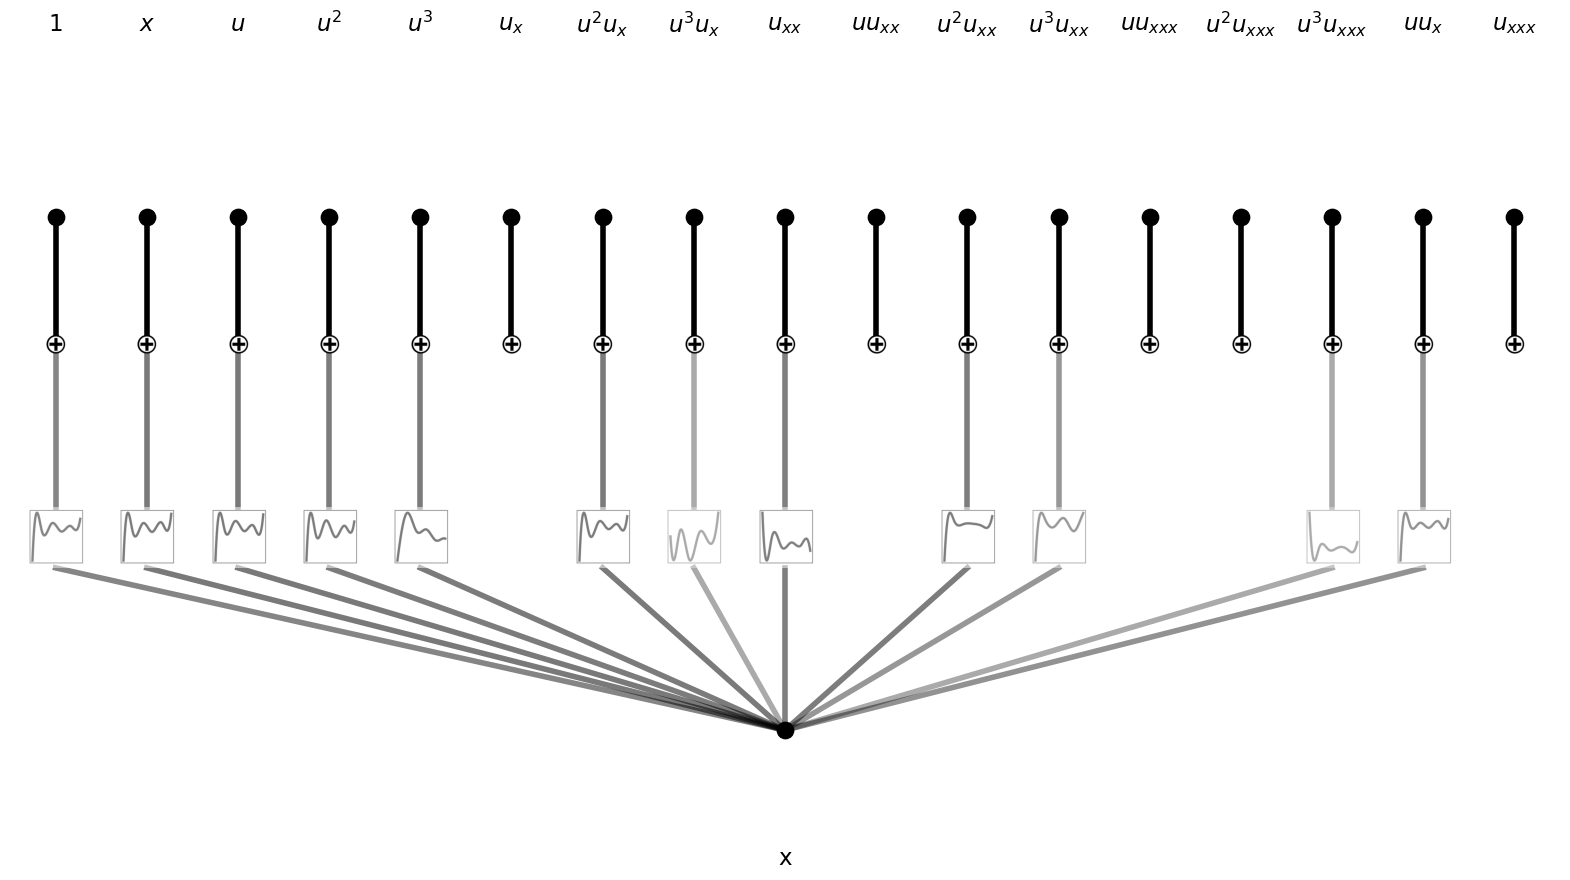

In [7]:
model.prune_kan(input_k)

saving model version 0.6


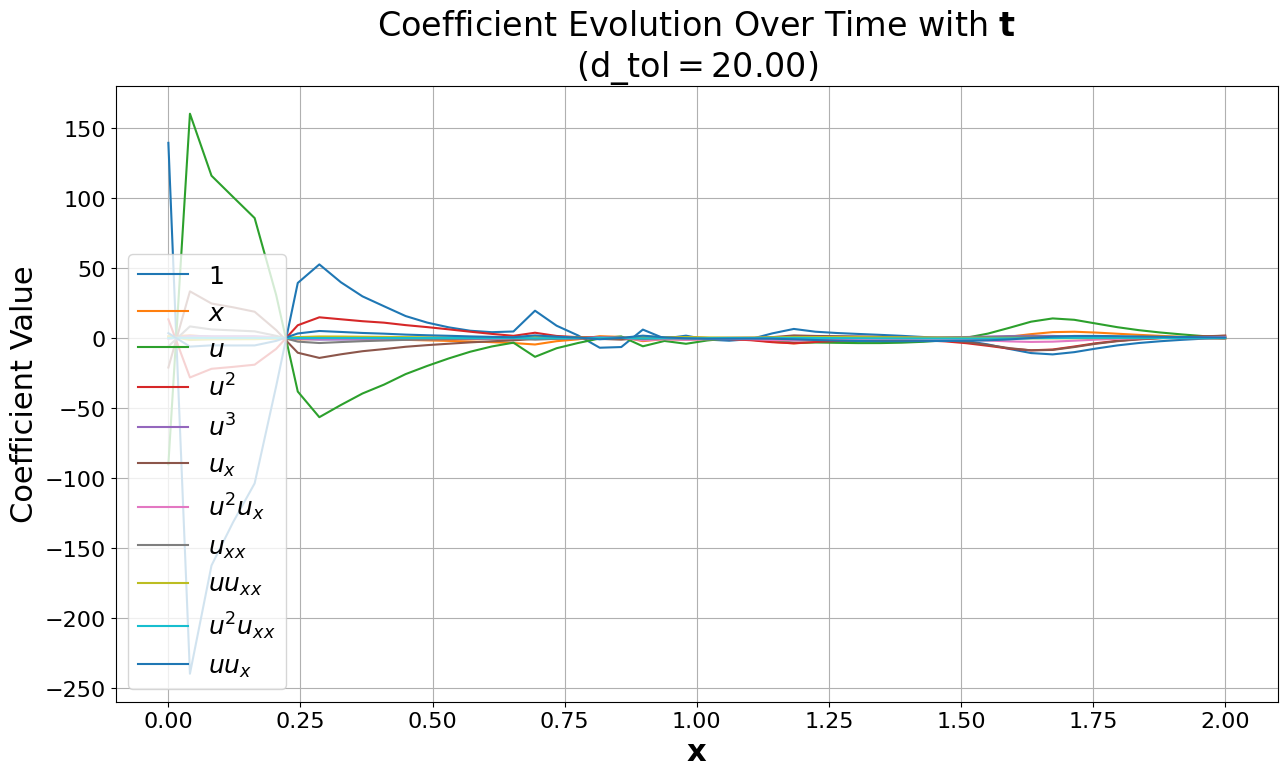

Plot saved as vc_plot/force_burgers_small_1.pdf


In [12]:
lam = 1e-5
d_tol =20
model.G_STRidge(input_k=input_k, x_steps=x_steps, t_steps=t_steps, d_tol=d_tol, lam=lam)
t = torch.linspace(0,2,t_steps)
model.ridge_plot(d_tol, t, filename='force_burgers_1')

saving model version 0.3
saving model version 0.4
saving model version 0.5
saving model version 0.6
saving model version 0.7


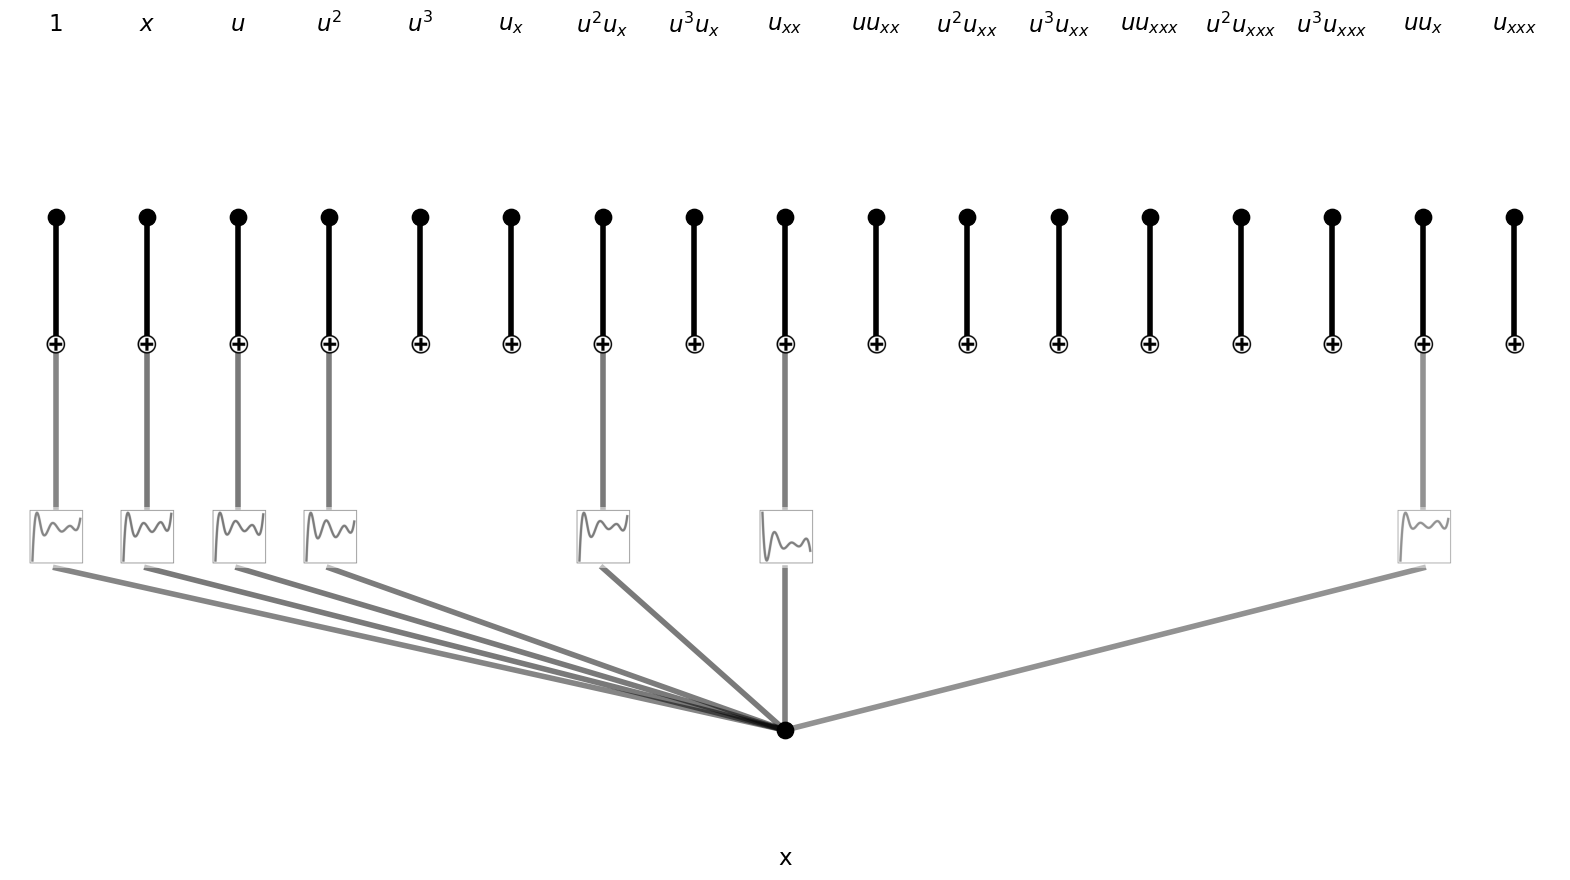

In [9]:
model.active_remove_edge(4)
model.active_remove_edge(7)
model.active_remove_edge(10)
model.active_remove_edge(11)
model.active_remove_edge(14)
model.kan_plot()


In [13]:
model.fit(input_r, input_k, U, steps=300, alpha=0.1, lam=0.001, lamb_l1=1., lamb_coef=0.5, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all',save_fig=True, img_folder='force_burgers_iter2')

  0%|          | 0/300 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 300/300 [41:41<00:00,  8.34s/it, loss=-4.49, loss_data=0.0102, loss_pde=0.00608, loss_reg=4.12]


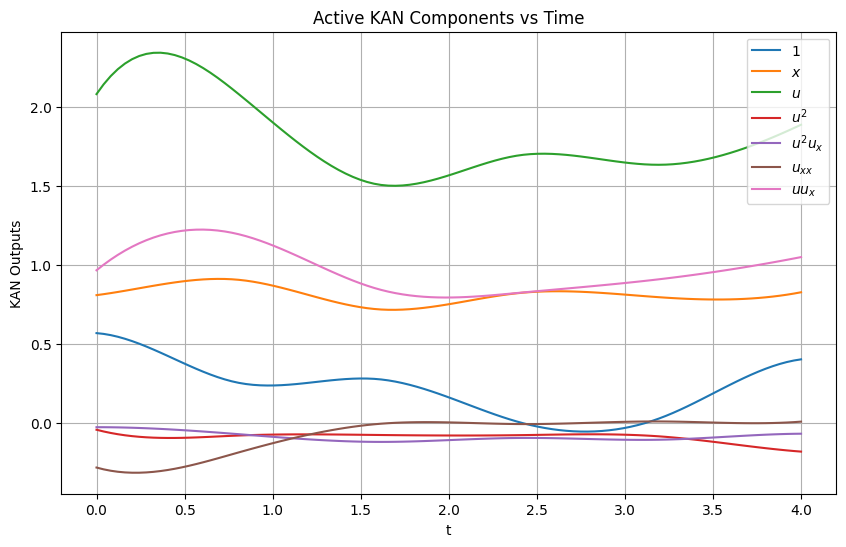

In [7]:
model.plot_kan_components()

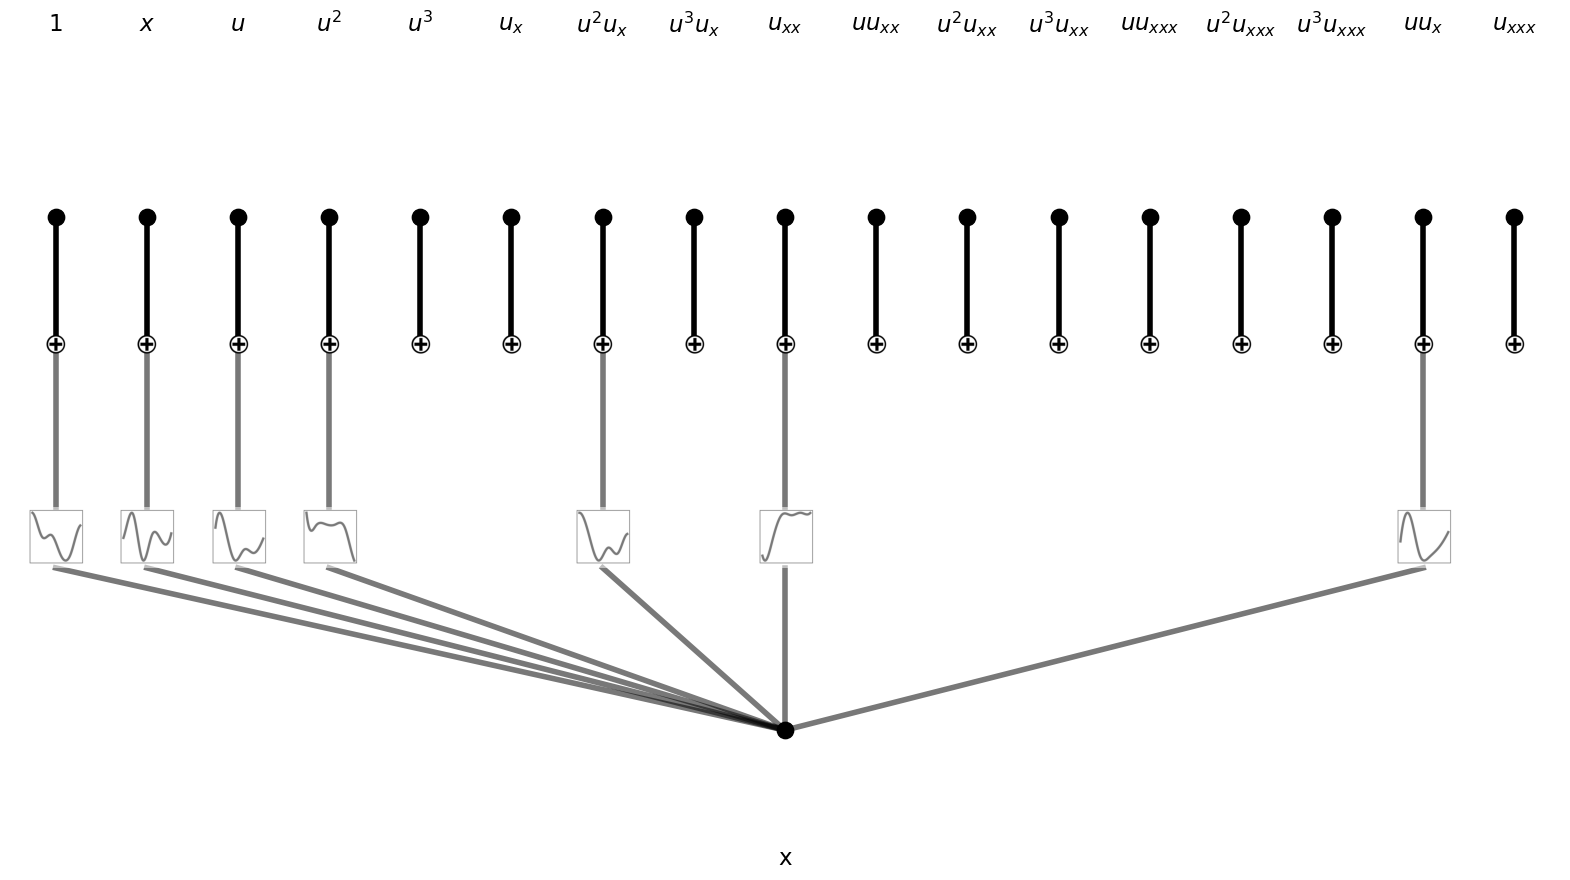

In [8]:
model.kan_plot()

Original:
After pruning:
saving model version 0.1


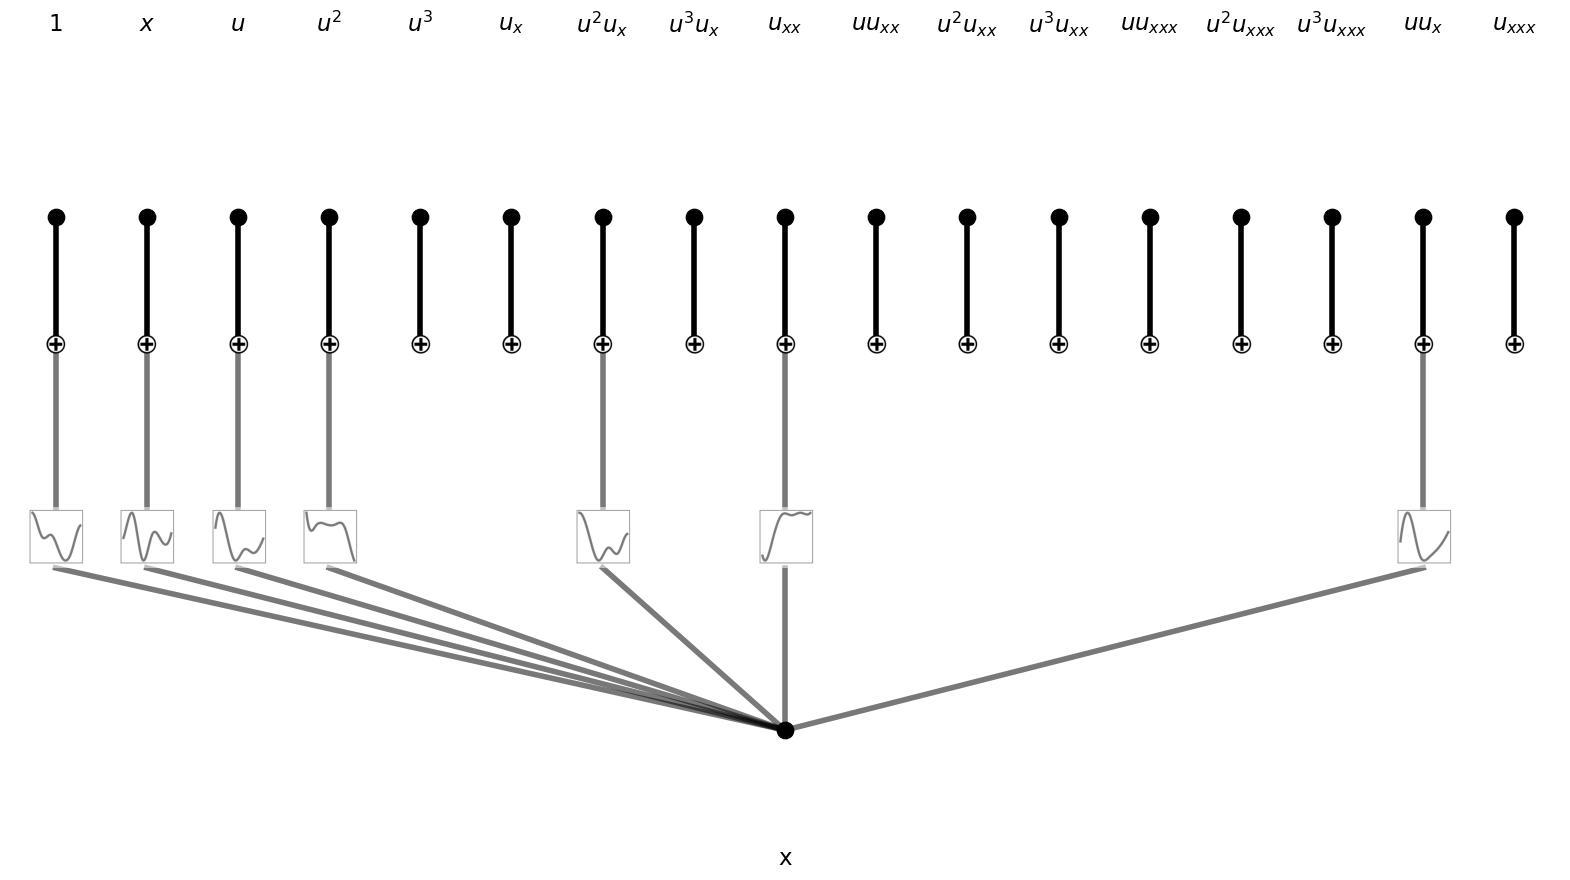

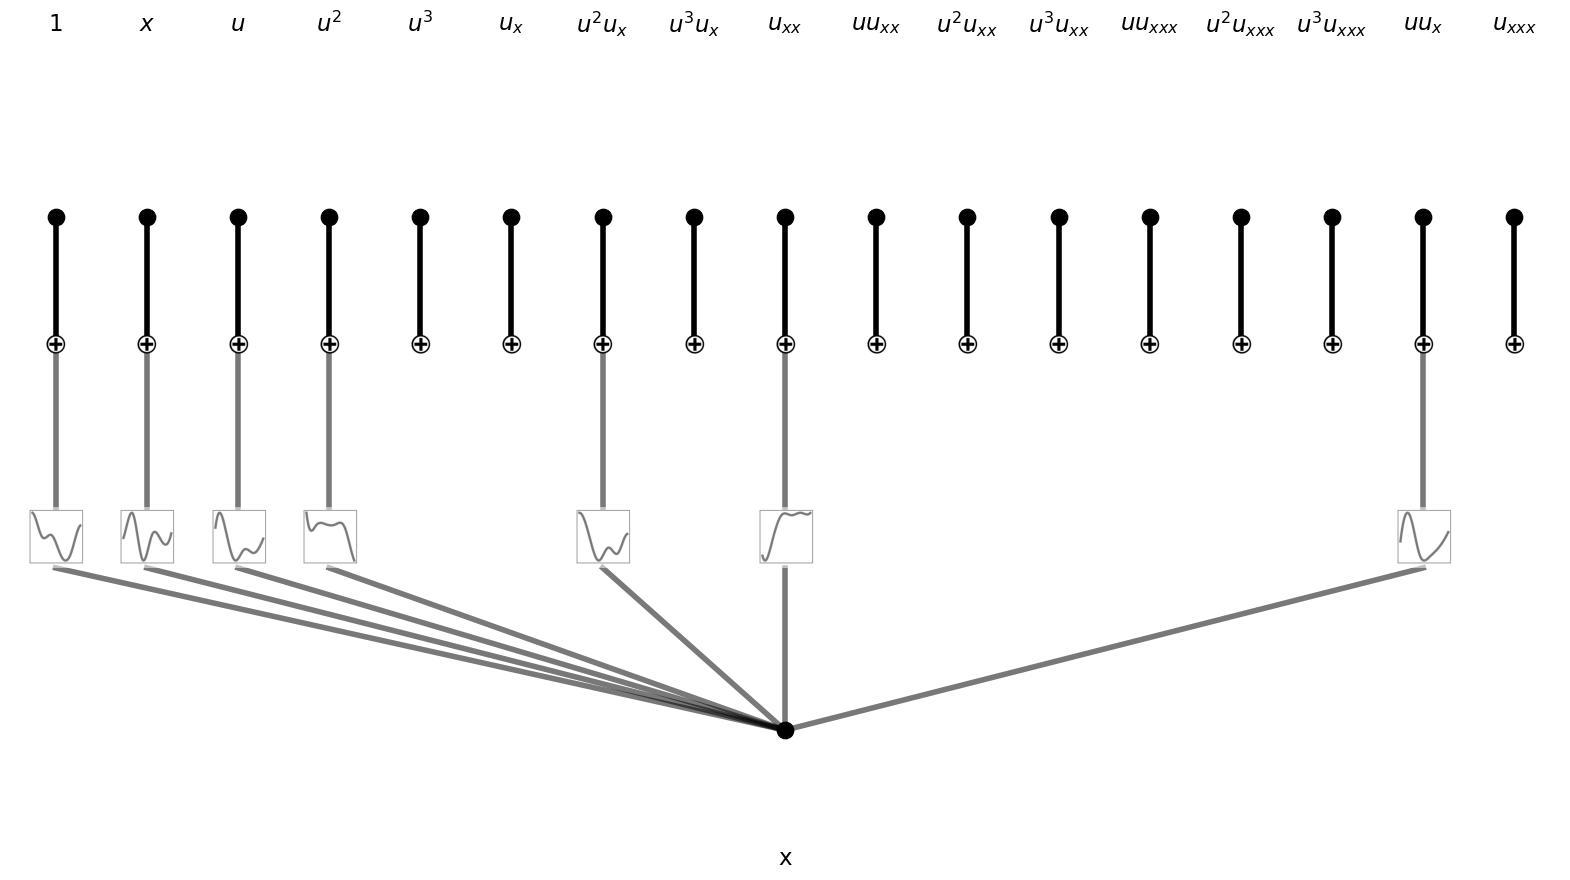

In [9]:
model.prune_kan(input_k)

saving model version 0.12


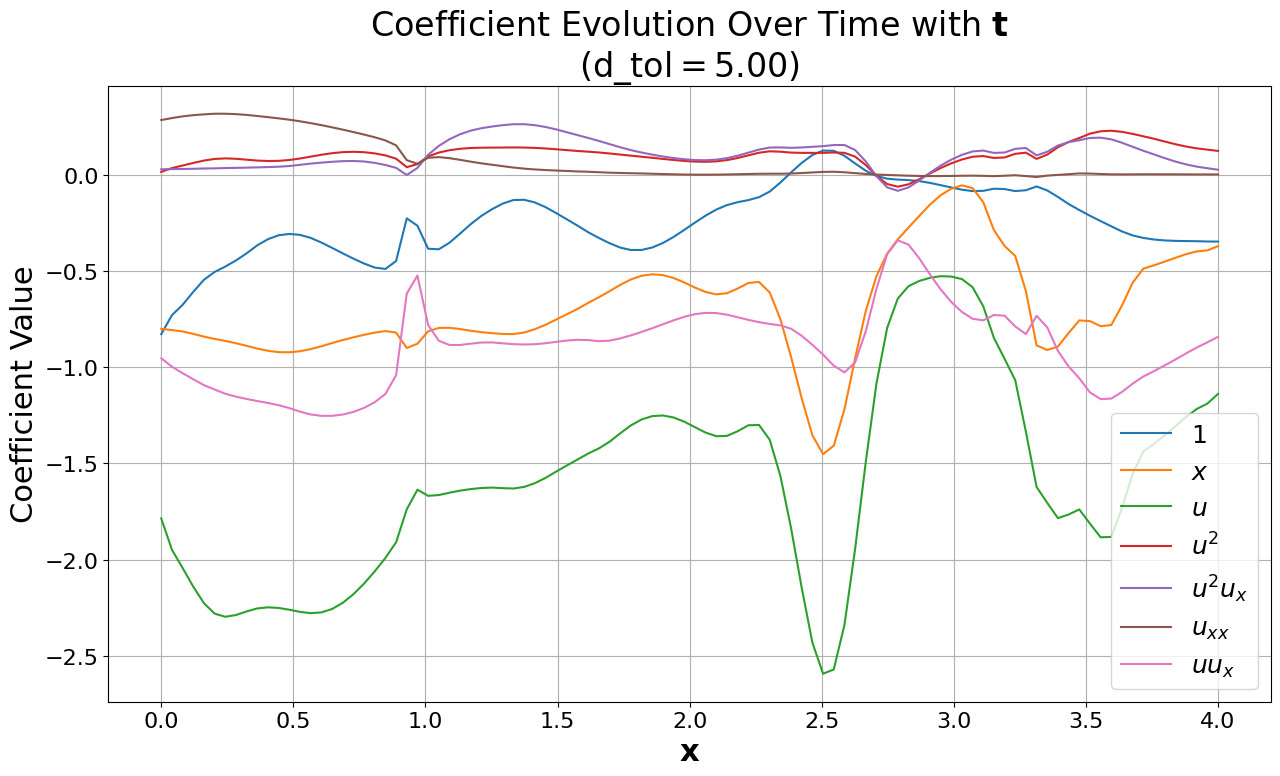

Plot saved as vc_plot/force_burgers_2.pdf


In [18]:
lam = 1e-5
d_tol = 5
model.G_STRidge(input_k=input_k, x_steps=x_steps, t_steps=t_steps, d_tol=d_tol, lam=lam)
t = torch.linspace(0,4,t_steps)
model.ridge_plot(d_tol, t, filename='force_burgers_2')

In [10]:
model.fit(input_r, input_k, U, steps=154, alpha=0.1, lam=0.01, lamb_l1=1., lamb_coef=0.5, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all',save_fig=True, img_folder='force_burgers_iter3')

  0%|          | 0/154 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 154/154 [17:52<00:00,  6.97s/it, loss=-4.44, loss_data=0.00968, loss_pde=0.00951, loss_reg=1.11]


Original:
After pruning:
saving model version 0.1


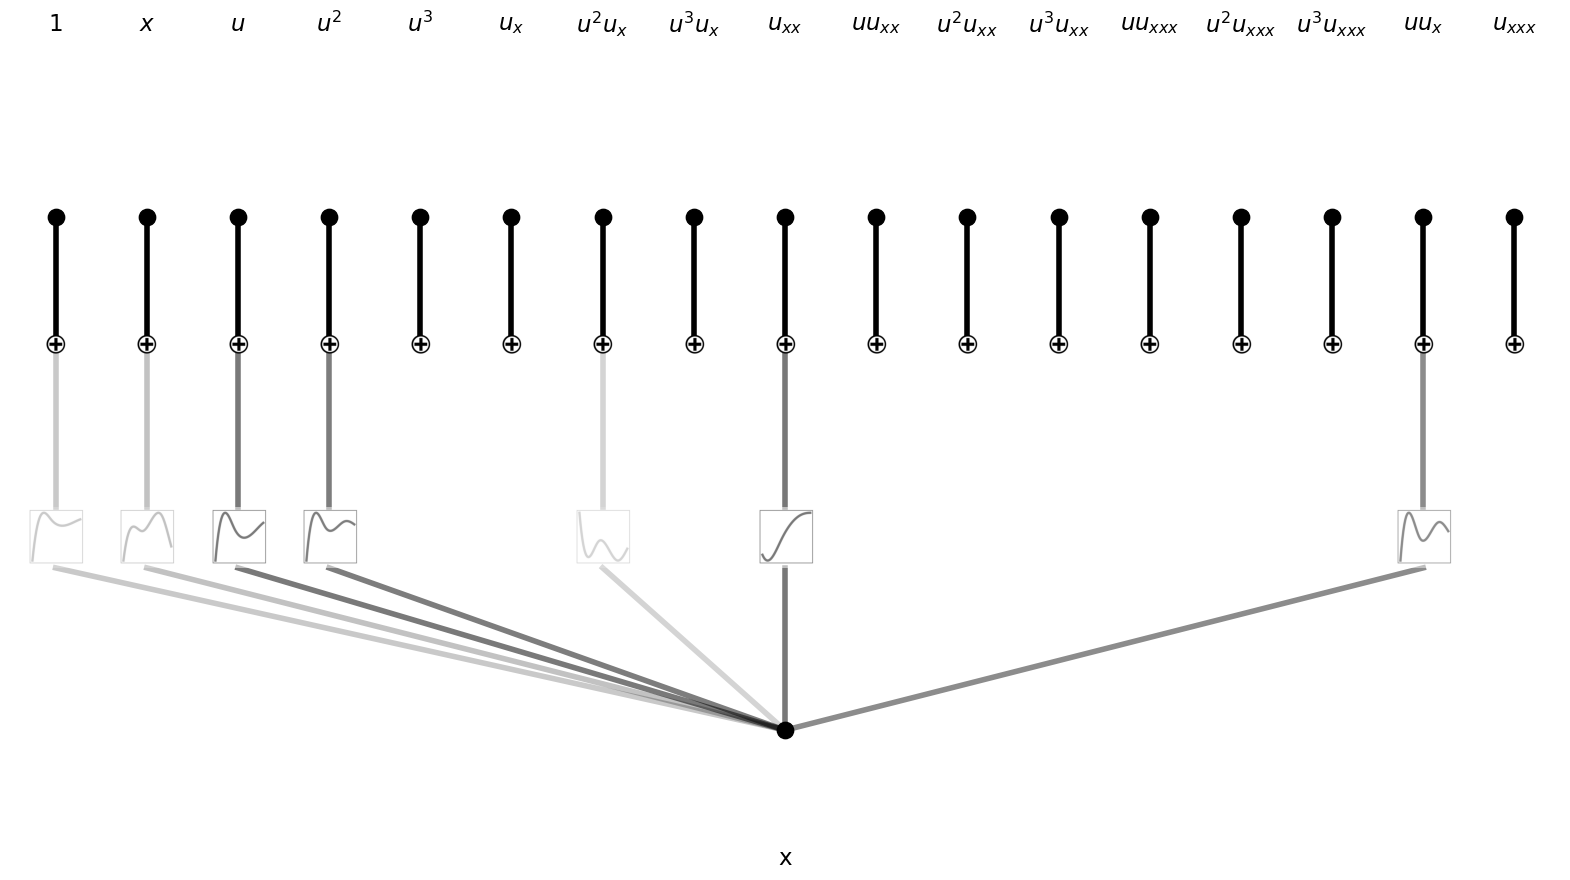

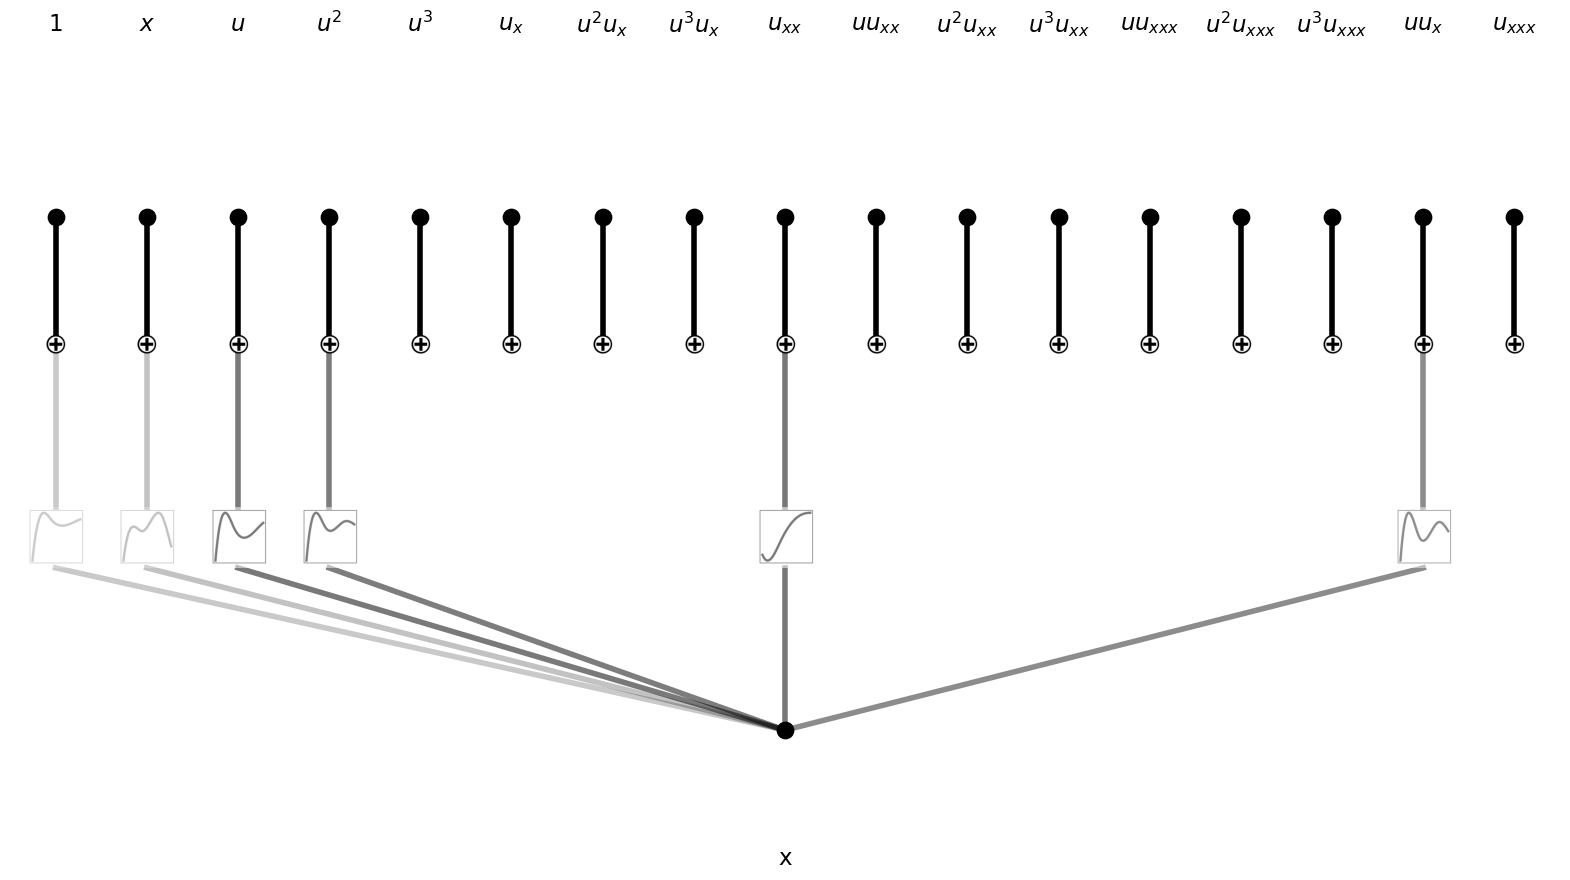

In [7]:
model.prune_kan(input_k,threshold=2e-2)

saving model version 0.2


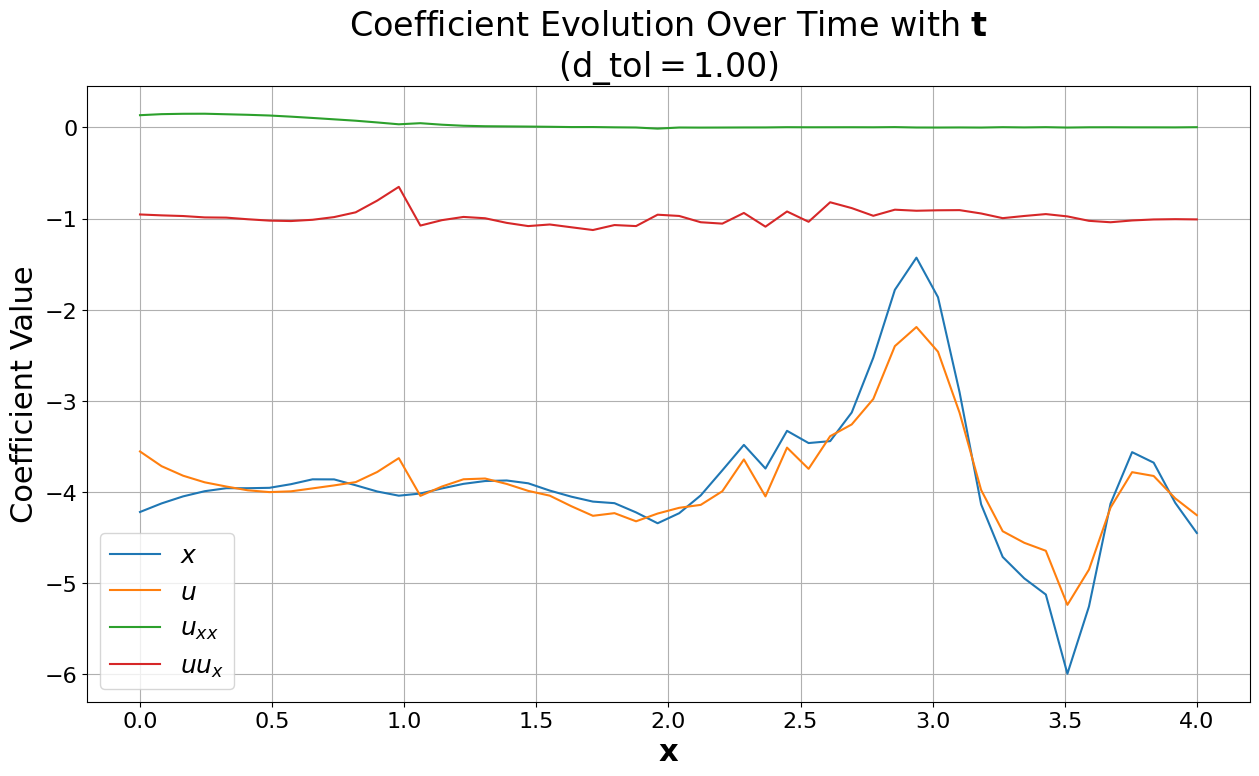

Plot saved as vc_plot/force_burgers_3.pdf


In [8]:
lam = 1e-5
d_tol = 1
model.G_STRidge(input_k=input_k, x_steps=x_steps, t_steps=t_steps, d_tol=d_tol, lam=lam)
t = torch.linspace(0,4,t_steps)
model.ridge_plot(d_tol, t, filename='force_burgers_3')

In [9]:
model.active_remove_edge(0)
model.active_remove_edge(3)
model.kan.refine(7)
model.fit(input_r, input_k, U, steps=100, alpha=1, lam=0.0, lamb_l1=1., lamb_coef=0.5, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all',save_fig=True, img_folder='force_burgers_iter4')

saving model version 0.3
saving model version 0.4
saving model version 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 100/100 [11:49<00:00,  7.10s/it, loss=-5.03, loss_data=0.00622, loss_pde=0.000298, loss_reg=2.8]


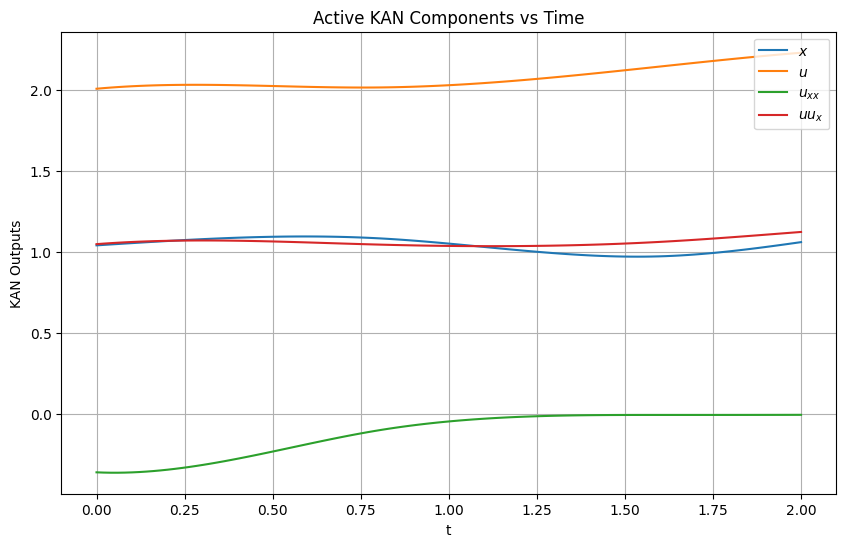

In [10]:
model.plot_kan_components()

In [11]:
torch.save(model.state_dict(), 'force_burgers_4.pt')

In [12]:
model.kan.auto_symbolic()

fixing (0,0,0) with 0
fixing (0,0,1) with 0, r2=0.0, c=0
fixing (0,0,2) with 0, r2=0.0, c=0
fixing (0,0,3) with 0
fixing (0,0,4) with 0
fixing (0,0,5) with 0
fixing (0,0,6) with 0
fixing (0,0,7) with 0
fixing (0,0,8) with gaussian, r2=0.9998689889907837, c=3
fixing (0,0,9) with 0
fixing (0,0,10) with 0
fixing (0,0,11) with 0
fixing (0,0,12) with 0
fixing (0,0,13) with 0
fixing (0,0,14) with 0
fixing (0,0,15) with 0, r2=0.0, c=0
fixing (0,0,16) with 0
saving model version 0.6


In [13]:
model.kan.fix_symbolic(0,0,1,'x')
model.kan.fix_symbolic(0,0,2,'x')
model.kan.fix_symbolic(0,0,8,'exp')
model.kan.fix_symbolic(0,0,15,'x')

Best value at boundary.
r2 is 0.4926462769508362
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.7
Best value at boundary.
r2 is 0.7746710777282715
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.8
r2 is 0.9619523286819458
saving model version 0.9
Best value at boundary.
r2 is 0.10459692776203156
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.10


-100000000.0

In [14]:
model.fit(input_r, input_k, U, steps=200, alpha=1, lam=0.0, lamb_l1=1., lamb_coef=0.5, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all',save_fig=True, img_folder='force_burgers_iter5')

  0%|          | 0/200 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 200/200 [23:49<00:00,  7.15s/it, loss=-4.76, loss_data=0.007, loss_pde=0.00153, loss_reg=0.301]  


In [16]:
model.kan.symbolic_formula()[0]

[0.000949783308897167,
 1.08747630675289 - 0.0737604601524353*x_1,
 0.0780651003714983*x_1 + 1.9583820889689,
 -0.00397498952224851,
 0.000983839156106114,
 -0.00462710112333298,
 -0.00644897716119885,
 0.000381902849767357,
 0.0415452048182487 - 0.46422142286358*exp(-1.27191841602325*x_1),
 -0.00403599441051483,
 0.000844585418235511,
 0.000176804387592711,
 -0.000227832453674637,
 -0.000160379058797844,
 1.02795893326402e-5,
 0.0153717386386664*x_1 + 1.04841071970336,
 -9.21965765883215e-5]

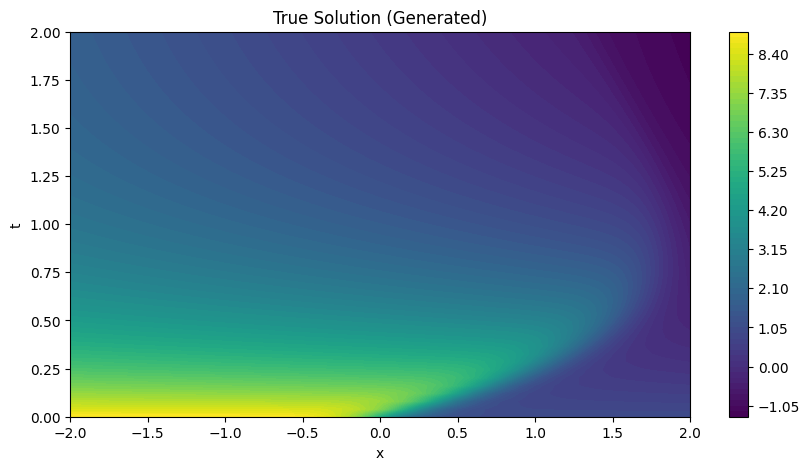

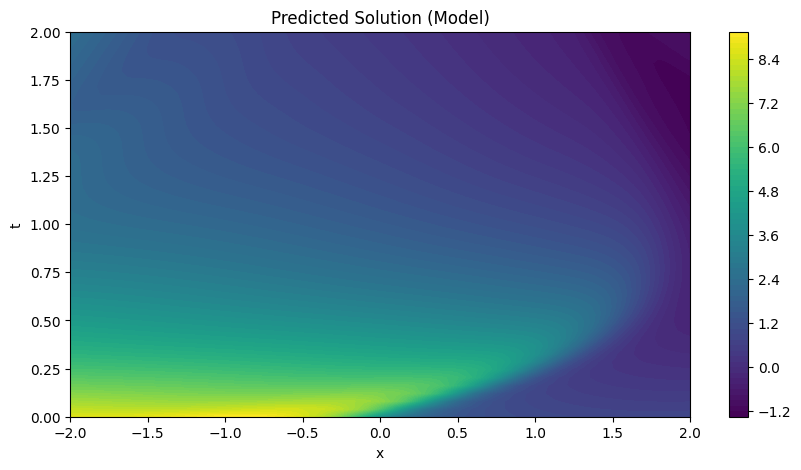

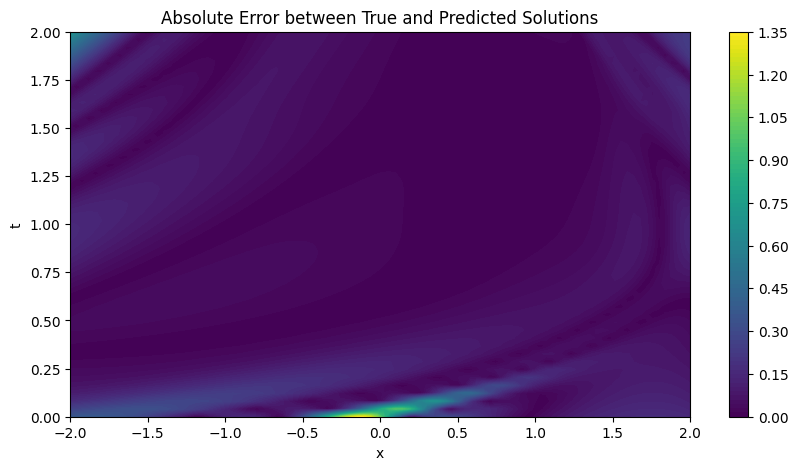

In [17]:
import matplotlib.pyplot as plt
shock_wave_func = lambdify_shock_wave_solution()

x_vals_plot = np.linspace(x_range[0], x_range[1], x_steps)
t_vals_plot = np.linspace(t_range[0], t_range[1], t_steps)

X_plot, T_plot = np.meshgrid(x_vals_plot, t_vals_plot, indexing='ij')
U_true_plot = shock_wave_func(X_plot, T_plot, c, A, gamma)  

X_k_plot = torch.tensor(X_plot.flatten(), dtype=torch.float32, requires_grad=True, device=device).unsqueeze(1)
T_k_plot = torch.tensor(T_plot.flatten(), dtype=torch.float32, requires_grad=True, device=device).unsqueeze(1)

input_plot = torch.cat([X_k_plot, T_k_plot], dim=1)

u_pred_plot, _, _, _ = model.forward(input_plot) 
u_pred_plot_np = u_pred_plot.cpu().detach().numpy().reshape(x_steps, t_steps)

error_plot = np.abs(U_true_plot - u_pred_plot_np)

plt.figure(figsize=(10, 5))
plt.contourf(X_plot, T_plot, U_true_plot, levels=100, cmap='viridis')
plt.colorbar()
plt.title('True Solution (Generated)')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(10, 5))
plt.contourf(X_plot, T_plot, u_pred_plot_np, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Predicted Solution (Model)')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(10, 5))
plt.contourf(X_plot, T_plot, error_plot, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Absolute Error between True and Predicted Solutions')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Active Indices: [ 1  2  8 15]


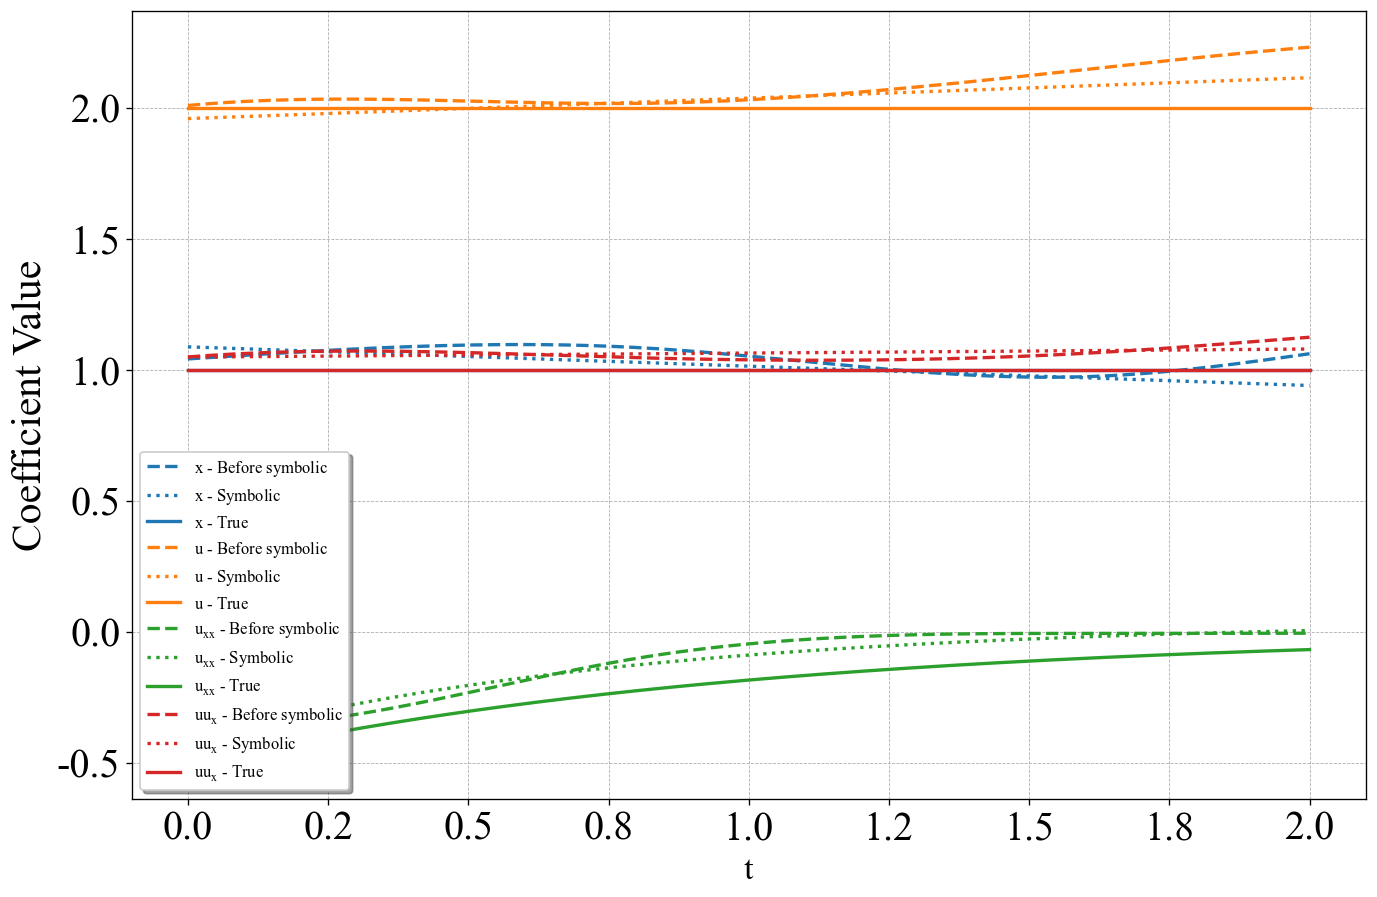

In [19]:
f1 = lambda t: np.ones_like(t)
f2 = lambda t: 2 * np.ones_like(t)
f3 = lambda t: -0.5*np.exp(-t)
f4 = lambda t: np.ones_like(t)
true_sol = {
    1: f1,
    2: f2,
    8: f3,
    15: f4
}

org_model = VC_PIKAN(Nd=Nd, Nh=Nh, Nb=Nb, rhs_des=rhs_des, range_x=x_range, range_t=t_range, seed=6666, grid=5, device=device)
org_model.load_state_dict(torch.load('force_burgers_4.pt'))

plot_variable_coefficients(org_model, model, true_sol, x_range, t_range, save_fig=True, file_name='force_burgers_One-shock')